In [61]:
###https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb

from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib
from matplotlib.pyplot import imshow
from scipy.spatial import distance

In [2]:
model = VGG16(weights='imagenet',include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
model.compile(optimizer='SGD', loss='categorical_crossentropy')

In [4]:
os.chdir("C:\\Users\\sudramak\\SuperDS projects\\Transfer Learning")
img = image.load_img('C:\\Users\\sudramak\\SuperDS projects\\Transfer Learning\\dog.jpg', target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

features = model.predict(x)

print('Predicted:', decode_predictions(features))

Predicted: [[('n02106550', 'Rottweiler', 0.81965047), ('n02107142', 'Doberman', 0.07956361), ('n02089078', 'black-and-tan_coonhound', 0.031070763), ('n02107574', 'Greater_Swiss_Mountain_dog', 0.024355184), ('n02107908', 'Appenzeller', 0.023130516)]]


In [5]:
####Extract the features for the input images##########
feat_ext = Model(input=model.input,output=model.get_layer('fc2').output)
feat_ext.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

C:\Users\sudramak\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  from ipykernel import kernelapp as app


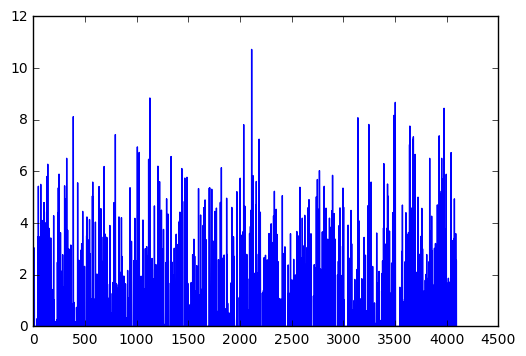

In [6]:
import matplotlib.pyplot as plt 
img = image.load_img('C:\\Users\\sudramak\\SuperDS projects\\Transfer Learning\\dog.jpg', target_size = (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)
y = feat_ext.predict(x)
plt.plot(y[0])
plt.show()

In [21]:
images_path = "C:\\Users\\sudramak\\SuperDS projects\\Transfer Learning"

In [22]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

In [31]:
import random
images = [images[i] for i in sorted(random.sample(range(len(images)),17))]

In [53]:
features =[]
img_load = []
for path in images:
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = feat_ext.predict(x)[0]
    img_load.append(img) 
    features.append(feat)

In [54]:
from sklearn.decomposition import PCA
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [64]:
def get_closest_images(query_image_idx, num_results=2):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

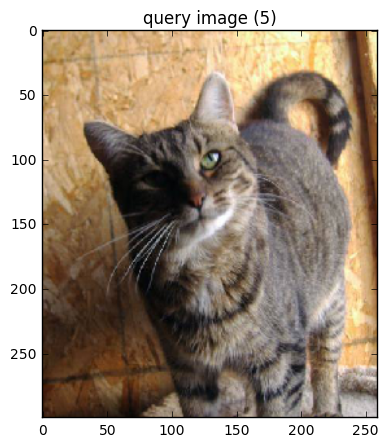

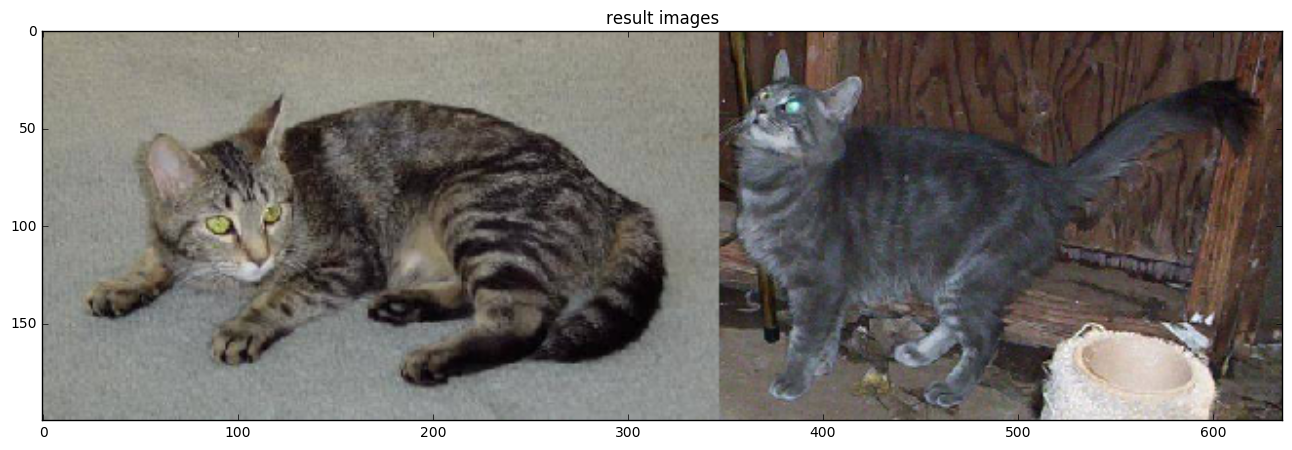

In [66]:
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)
%matplotlib inline
# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")